In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

### Simulation

In [2]:
sim = rw.Simulation()

nr_particles = 1*10**1
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
energy = 10**12 # eV
source = rw.PointSourceIsotropicPhi(energy, source_pos, nr_particles)
sim.add_source(source)

nr_steps = 1*10**5
step_size = 0.5*10**10 # [m]
diffusion_coefficient = 1.5*10**20 # [m^2/s]
speed_of_light = 3*10**8 # [m/s]
mfp_iso = 3*diffusion_coefficient/speed_of_light
mfp = np.array([mfp_iso, mfp_iso, mfp_iso], dtype=np.float32)  # [m]
propagator = rw.IsotropicPropagator(mfp, nr_steps, step_size)
sim.add_propagator(propagator)

substeps = [False, False, True] # observe only steps (no substeps)
#min_step = 1
#max_step = nr_steps
#nr_obs_steps = 200
#observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
spheres = [10**13]
observer = rw.SphericalObserver(substeps, spheres, on_detection_deactivate=True)
sim.add_observer(observer)

%time sim.run_simulation()
sim.save_data('data/data_tut_5')

start simulation
Propagator initialized
Observer initialized
CPU times: user 2.86 s, sys: 8.79 ms, total: 2.87 s
Wall time: 2.87 s
saved data file data/data_tut_5.pkl


### Analysis

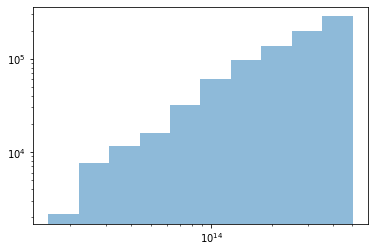

In [4]:
df = pd.read_pickle("data/data_tut_5.pkl")
bins = 10
hist, bins = np.histogram(df['d'], bins=bins)
logbins = np.logspace(np.log10(min(df['d'])),np.log10(max(df['d'])),len(bins))
plt.hist(df['d'], bins=logbins, alpha=0.5)

plt.loglog()
plt.show()

In [15]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,63415.0,2.533771e+16,6.281554e+13,-4.618798e+13,6.281554e+13,4.042288,4.096986,1.000000e+14,2.0
1,0.0,63417.0,2.533851e+16,6.281554e+13,-4.618798e+13,6.281554e+13,4.042288,4.096986,1.000000e+14,2.0
2,0.0,63420.0,2.533971e+16,6.258460e+13,-4.595704e+13,6.304648e+13,4.042288,4.096986,1.000000e+14,2.0
3,0.0,63422.0,2.534051e+16,6.304648e+13,-4.595704e+13,6.304648e+13,4.042288,4.096986,1.000000e+14,2.0
4,0.0,63423.0,2.534091e+16,6.327742e+13,-4.572610e+13,6.327742e+13,4.042288,4.096986,1.000000e+14,2.0
...,...,...,...,...,...,...,...,...,...,...
4572401,19.0,399996.0,1.626086e+17,1.009204e+14,-2.563437e+13,-7.136027e+13,1.252278,0.955393,1.000000e+14,2.0
4572402,19.0,399997.0,1.626090e+17,1.011513e+14,-2.586531e+13,-7.159121e+13,1.252278,0.955393,1.000000e+14,2.0
4572403,19.0,399998.0,1.626095e+17,1.009204e+14,-2.563437e+13,-7.136027e+13,1.252278,0.955393,1.000000e+14,2.0
4572404,19.0,399999.0,1.626099e+17,1.011513e+14,-2.586531e+13,-7.159121e+13,1.252278,0.955393,1.000000e+14,2.0


In [20]:
sim = rw.IsotropicSimulation(nr_particles = 10**2, energy = energy, nr_steps = nr_steps, diffusion_coefficient_para = diffusion_coefficient, nr_obs_steps = 600)
%time sim.simulate()

simulate with a diffusion coefficient of  1.5e+20 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file isotropic.pkl
CPU times: user 2min 37s, sys: 63.9 ms, total: 2min 37s
Wall time: 2min 37s


init statistics plotting class


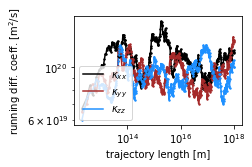

diffusion coefficients computed between 1.02e+17m and 1.02e+18m with 100 data points
kappa_{xx}: 1.05e+20 m²/s +- 9.1e+18 m²/s
kappa_{yy}: 9.88e+19 m²/s +- 1.27e+19 m²/s
kappa_{zz}: 9.2e+19 m²/s +- 1.2e+19 m²/s


In [21]:
df = pd.read_pickle("isotropic.pkl")
sta = rw.Statistics(df)
df_kappas = sta.plot_diffusion_coefficients(n_points_plateau=100)